<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/comment/ch04_01_UNet_Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.01 UNet-Image segmentation

* 날짜:
* 이름:

## 학습내용
    - Image segmentation에 대해 이해한다.
    - UNet 모델에 대해 이해한다.
    - 이미지 분절 작업을 수행한다.

## Image Segmentation

![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_type.png?raw=true)


![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_model.png?raw=true)

## 모델: UNet
---

![]( https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/unet2.png?raw=true)

#### **레포지토리 임포트**

https://github.com/karolzak/keras-unet

```
! git clone https://github.com/karolzak/keras-unet
```


In [2]:
! git clone https://github.com/karolzak/keras-unet

Cloning into 'keras-unet'...
remote: Enumerating objects: 1234, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1234 (delta 44), reused 75 (delta 34), pack-reused 1136
Receiving objects: 100% (1234/1234), 31.94 MiB | 26.00 MiB/s, done.
Resolving deltas: 100% (372/372), done.


In [34]:
import sys, os, glob
sys.path.append('/content/keras-unet')

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils, callbacks
from keras_unet.models import custom_unet
from PIL import Image

#### **모델 생성**

In [ ]:
from keras_unet.models import vanilla_unet

model = vanilla_unet(input_shape=(572, 572, 3))
model.summary()

In [ ]:
utils.plot_model(model, show_shapes=True)

In [ ]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(512, 512, 3),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid')

utils.plot_model(model, show_shapes=True)

## 데이터셋: Whale-tails
---

### **| 데이터 처리**

#### **데이터 경로 확보**

In [12]:
img_paths = glob.glob('/content/keras-unet/input/whales/*jpg')
mask_paths = glob.glob('/content/keras-unet/input/whales/*png')
print(len(img_paths), img_paths[0])
print(len(mask_paths), mask_paths[0])

500 /content/keras-unet/input/whales/00d641885.jpg
148 /content/keras-unet/input/whales/00e4afee9.png


In [14]:
img_paths = [mask_path.replace('png', 'jpg') for mask_path in mask_paths]
print(len(img_paths), img_paths[0])

148 /content/keras-unet/input/whales/00e4afee9.jpg


#### **넘파이 변환**

In [18]:
from PIL import Image
imgs = []
masks = []
for img_path, mask_path in zip(img_paths, mask_paths):
  # path2img
  img = Image.open(img_path).resize( (384,384) )
  img = np.array(img)
  imgs.append(img)
  # path2mask
  mask = Image.open(mask_path).resize( (384,384) )
  mask = np.array(mask)
  masks.append(mask)
imgs = np.asarray(imgs)
masks = np.asarray(masks)
masks = np.expand_dims(masks, 3)

imgs.shape, masks.shape

((148, 384, 384, 3), (148, 384, 384, 1))

#### **데이터 확인**

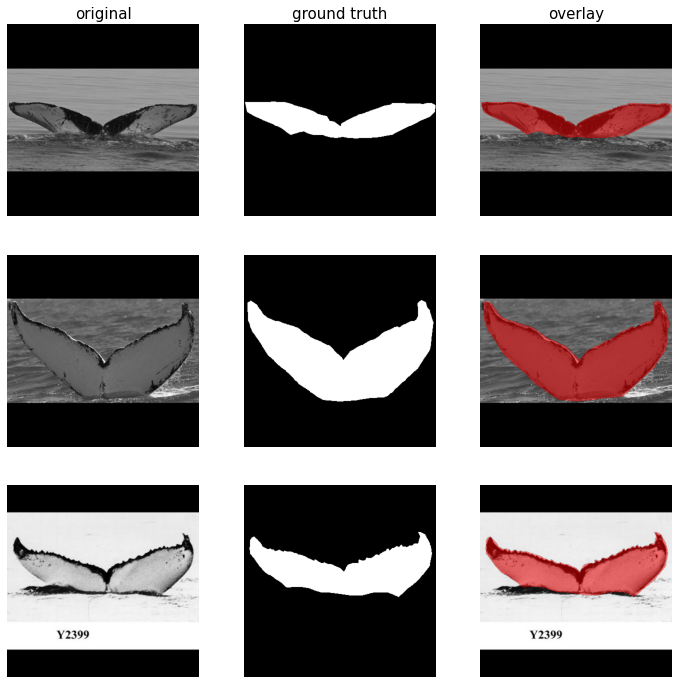

In [20]:
from keras_unet.utils import plot_imgs
plot_imgs(imgs, masks, nm_img_to_plot=3)

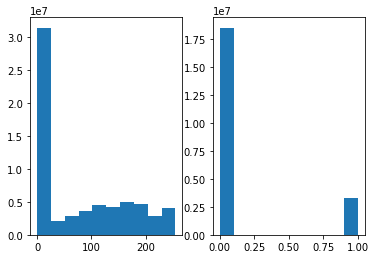

In [22]:
plt.subplot(121);_=plt.hist(imgs.flatten())
plt.subplot(122);_=plt.hist(masks.flatten())

In [23]:
mn, mx = np.min(imgs.flatten()), np.max(imgs.flatten())
print(f'인풋 이미지의 값 범위: {mn}, {mx}')
print(f'마스크의 값 범위: { set( mask.flatten() ) }')

인풋 이미지의 값 범위: 0, 255
마스크의 값 범위: {0, 1}


#### **전처리**

In [24]:
def whale_preprocess(imgs, masks):
  imgs = imgs/255.0
  return imgs, masks

인풋 이미지의 값 범위: 0.0, 1.0
마스크의 값: {0, 1}


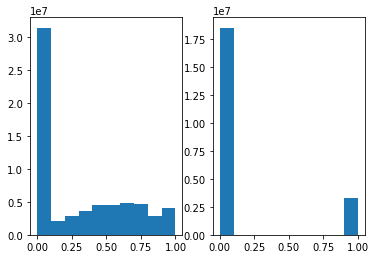

In [26]:
imgs_ds, masks_ds = whale_preprocess(imgs, masks)
mn, mx = np.min(imgs_ds.flatten()), np.max(imgs_ds.flatten())
print(f'인풋 이미지의 값 범위: {mn}, {mx}')
print(f'마스크의 값: { set( masks_ds.flatten() ) }')
plt.subplot(121);_=plt.hist(imgs_ds.flatten())
plt.subplot(122);_=plt.hist(masks_ds.flatten())

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(imgs_ds, masks_ds, 
                                                    test_size=0.1, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((133, 384, 384, 3), (15, 384, 384, 3), (133, 384, 384, 1), (15, 384, 384, 1))

#### **이미지 증강**

In [29]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(x_train, y_train, 
                          batch_size=2,
                          data_gen_args=dict(rotation_range=5.0, 
                                             height_shift_range=0.05,
                                             width_shift_range=0.05,
                                             shear_range=40,
                                             horizontal_flip=True, 
                                             vertical_flip=False, 
                                             fill_mode='constant'))

(2, 384, 384, 3) (2, 384, 384, 1)


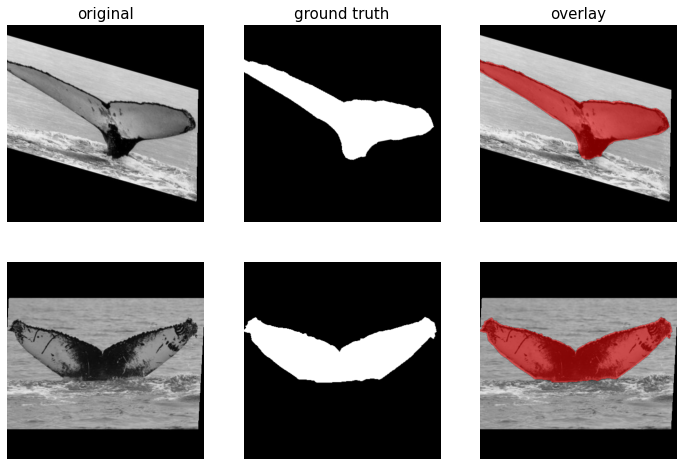

In [31]:
samples = next(train_gen)
xs, ys = samples
print(xs.shape, ys.shape)
plot_imgs(xs, ys, nm_img_to_plot=2)

### **| 모델 생성 및 학습**

#### **모델 생성**

In [ ]:
model = custom_unet( (384,384,3),
                    filters=32, output_activation='sigmoid')
model.summary()

#### **컴파일 및 학습**

In [35]:
# 콜백-체크포인트
ckp = callbacks.ModelCheckpoint('unet_whale.h5',
                                monitor='val_loss',
                                save_best_only=True)

In [36]:
from keras_unet.metrics import iou

model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=[ iou ] ) # 케라스에서 iou 함수 지원하지 않음

In [40]:
history = model.fit(train_gen,
                    epochs=50,
                    steps_per_epoch=200,
                    validation_data=(x_test, y_test),
                    callbacks=[ckp])

Epoch 1/50
200/200 [==============================] - 16s 82ms/step - loss: 0.3007 - iou: 0.3314 - val_loss: 4.9945 - val_iou: 0.2499
Epoch 2/50
200/200 [==============================] - 15s 75ms/step - loss: 0.2253 - iou: 0.4068 - val_loss: 0.6327 - val_iou: 0.3857
Epoch 3/50
200/200 [==============================] - 15s 76ms/step - loss: 0.1861 - iou: 0.4877 - val_loss: 0.1373 - val_iou: 0.5382
Epoch 4/50
200/200 [==============================] - 15s 76ms/step - loss: 0.1508 - iou: 0.5606 - val_loss: 0.1147 - val_iou: 0.6652
Epoch 5/50
200/200 [==============================] - 15s 76ms/step - loss: 0.1362 - iou: 0.5999 - val_loss: 0.0856 - val_iou: 0.7146
Epoch 6/50
200/200 [==============================] - 15s 73ms/step - loss: 0.1242 - iou: 0.6345 - val_loss: 0.0890 - val_iou: 0.7521
Epoch 7/50
200/200 [==============================] - 15s 73ms/step - loss: 0.1081 - iou: 0.6683 - val_loss: 0.0972 - val_iou: 0.7263
Epoch 8/50
200/200 [==============================] - 15s 76ms

#### **Plot training history**

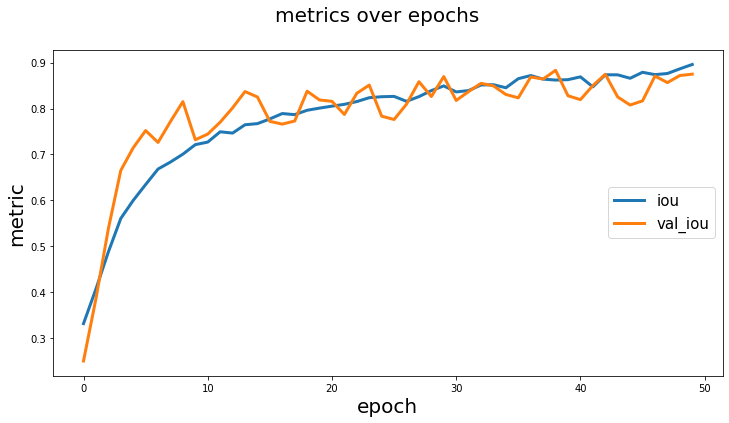

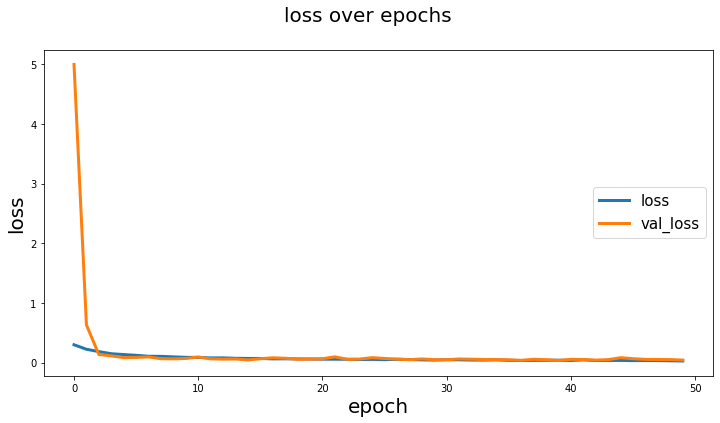

In [41]:
from keras_unet.utils import plot_segm_history

plot_segm_history(
    history, # required - keras training history object
    metrics=['iou', 'val_iou'], # optional - metrics names to plot
    losses=['loss', 'val_loss']) # optional - loss names to plot

#### **Plot original + ground truth + pred + overlay (pred on top of original)**

In [42]:
y_pred = model.predict(x_test)
print(y_test.shape, y_pred.shape)

(15, 384, 384, 1) (15, 384, 384, 1)


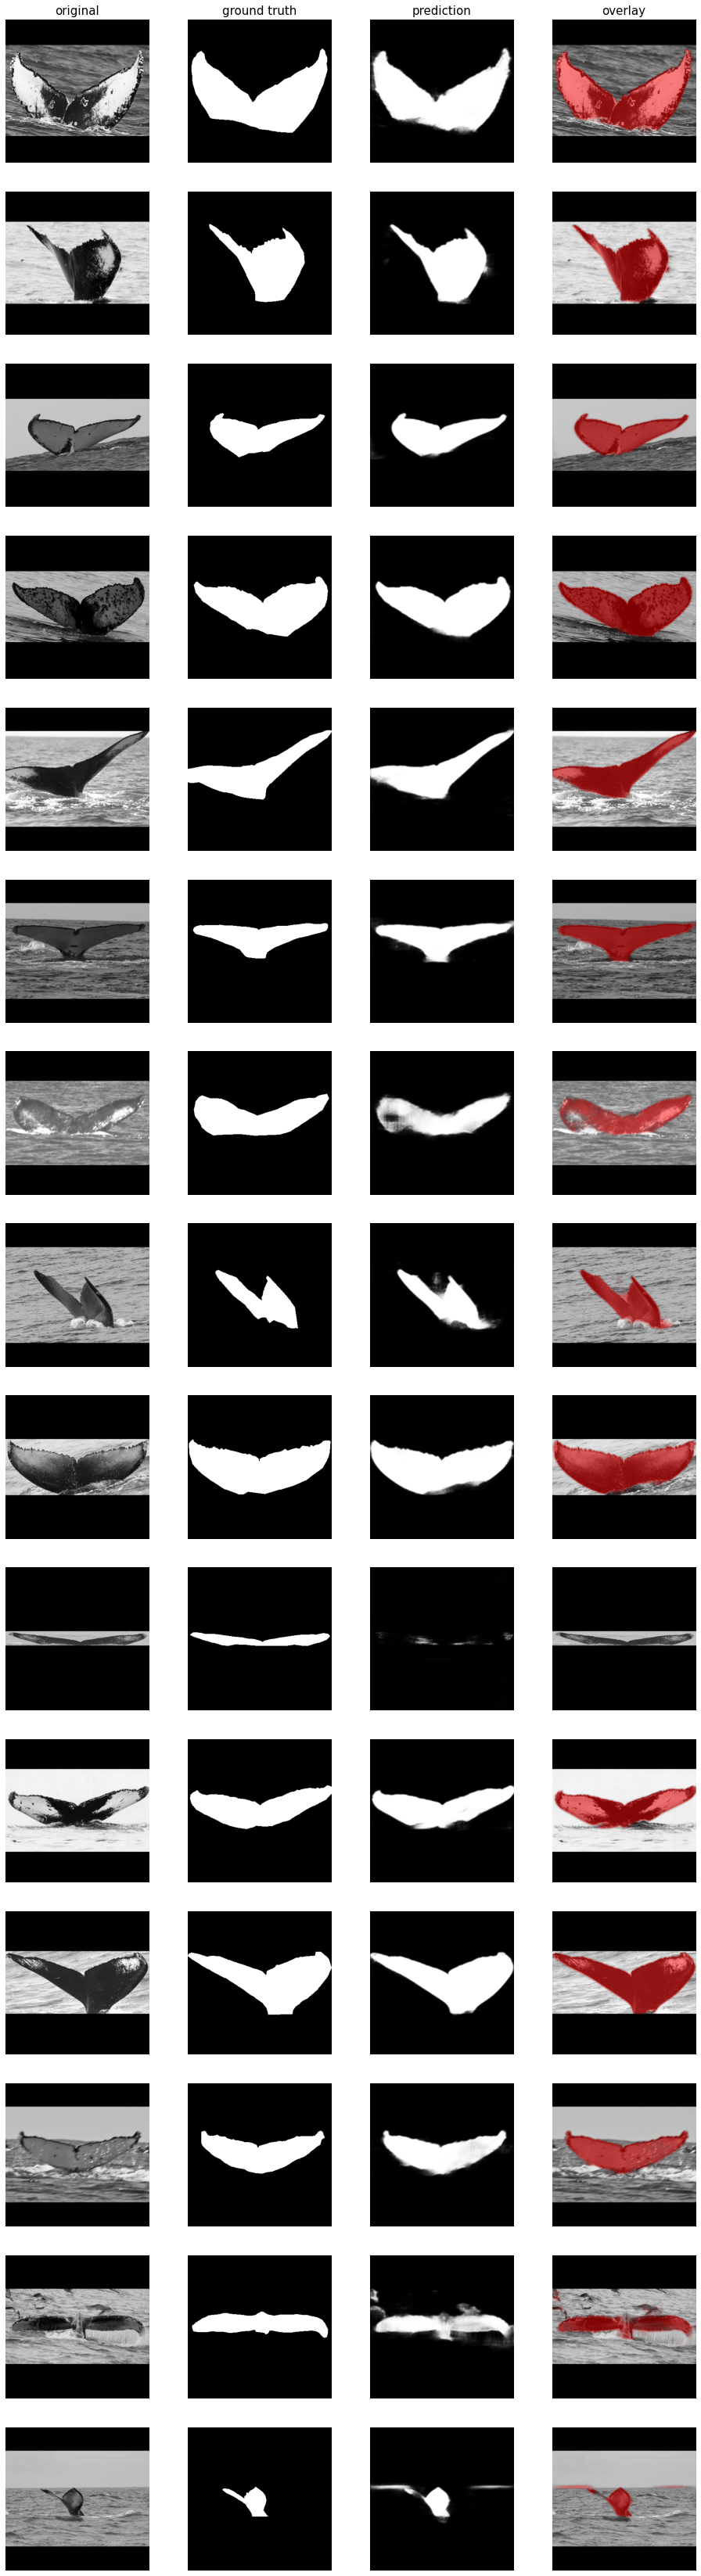

In [43]:
plot_imgs(org_imgs = x_test,
          mask_imgs= y_test,  
          pred_imgs= y_pred,
          nm_img_to_plot=15)

## 데이터셋: kz-isbi-challenge
---

https://github.com/karolzak/keras-unet/blob/master/notebooks/kz-isbi-challenge.ipynb